In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib.gridspec import GridSpec
plt.rc('font', family='Times New Roman')  

In [184]:
def load_carbon_counts():
    # Load the carbon counts from the "Balance" sheet in the Products Excel file
    df_carbon = pd.read_excel('Products.xlsx', sheet_name='Balance', header=0, index_col=0)
    carbon_counts = df_carbon.loc['C'].to_dict()  # Extract carbon counts as a dictionary
    return carbon_counts

def load_hydrogen_counts():
    # Load the hydrogen counts from the "Balance" sheet in the Products Excel file
    df_carbon = pd.read_excel('Products.xlsx', sheet_name='Balance', header=0, index_col=0)
    hydrogen_counts = df_carbon.loc['H'].to_dict()  # Extract hydrogen counts as a dictionary
    return hydrogen_counts

def normalize_product_name(product_name):
    # Remove suffixes like ".1", ".2", ".3" from product names for consistency
    return re.sub(r'\.\d+$', '', product_name)

def get_yields(sheet, metabolite, carbon_counts, hydrogen_counts):
    # Load substrate and product data from the respective sheets
    df = pd.read_excel('Substrates.xlsx', sheet_name=sheet, index_col=0).fillna(0)
    df2 = pd.read_excel('Products.xlsx', sheet_name='Products', index_col=0).fillna(0)
    
    if metabolite not in df.columns:
        # Check if the specified metabolite is in the substrates sheet
        print(f"Error: Metabolite '{metabolite}' not found in substrate row titles.")
        return
    
    Substrates, Products = df.to_numpy(), df2.to_numpy()
    substrate_col_titles = df.columns
    # Identify indices for specific carbon sources
    carbon_source_indices = {source: i for i, source in enumerate(substrate_col_titles) if source in ['CO2', 'CO', 'Formate', 'Methanol', 'Acetate Sink']}
    
    yield_data = {}
    metabolite_idx = list(substrate_col_titles).index(metabolite)
    
    for i in range(Products.shape[1]):
        product_name = df2.columns[i]
        normalized_product_name = normalize_product_name(product_name)  # Normalize product name
        column_to_append = Products[:, i].reshape(-1, 1)
        new_matrix = np.hstack((Substrates, column_to_append))  # Combine substrates and product column
        non_zero_mask = (new_matrix != 0).any(axis=1)  # Remove rows with all zeros
        new_matrix = new_matrix[non_zero_mask]
        
        if new_matrix.shape[0] == new_matrix.shape[1]:  # Ensure matrix is square for solving
            b = np.zeros(new_matrix.shape[0])
            b[-1] = 1  # Balance equation (last row)
            
            try:
                x = np.linalg.solve(new_matrix.astype(float), b.astype(float))
                x[np.isclose(x, 0, atol=1e-10)] = 0
                
                acetate_included = True
                
                # Special handling for acetate sink if present
                if sheet not in ["CO2 Sequential Culture", "CO Sequential Culture", "Formate Sequential Culture", "Methanol Sequential Culture"]:
                    if "Acetate Sink" in substrate_col_titles:
                        acetate_sink_idx = list(substrate_col_titles).index("Acetate Sink")
                        if x[acetate_sink_idx] < 0:
                            new_matrix[:, acetate_sink_idx] = np.roll(new_matrix[:, acetate_sink_idx], shift=1)
                            x = np.linalg.solve(new_matrix.astype(float), b.astype(float))
                            acetate_included = False
                       
                if x[metabolite_idx] != 0:
                    yield_value = abs(1 / x[metabolite_idx])  # Calculate yield
                    yield_sum = 0

                    # Calculate carbon balance for the yield
                    for source, idx in carbon_source_indices.items():
                        if x[idx] != 0:
                            if source == 'Acetate Sink' and acetate_included:
                                yield_sum += x[idx] * 2
                            elif source not in ['Acetate Sink']:
                                yield_sum += x[idx]
                                
                    product_carbon_count = carbon_counts.get(product_name, None)
                    product_hydrogen_count = hydrogen_counts.get(product_name, None)
                    
                    if product_carbon_count is None:
                        # Skip if carbon count for the product is missing
                        print(f"Carbon count for product '{product_name}' not found. Skipping balance check.")
                        yield_data[product_name] = np.nan
                        continue

                    if abs(yield_sum) < product_carbon_count - (1e-4):
                        # Check for carbon imbalance
                        print(f"Carbon imbalance for product '{product_name}': Used={yield_sum}, Expected={product_carbon_count} (in {sheet})")
                        yield_data[product_name] = np.nan
                    else:
                        # Adjust yield value based on carbon/hydrogen count
                        if sheet in pd.ExcelFile('Substrates.xlsx').sheet_names[:3]:
                            count = product_hydrogen_count
                        else:
                            count = product_carbon_count
                        adjusted_yield_value = yield_value * count * 100

                        # Store or update the maximum yield value
                        if normalized_product_name in yield_data:
                            current_yield = yield_data[normalized_product_name]
                            if np.isnan(current_yield) or current_yield == 0:
                                yield_data[normalized_product_name] = adjusted_yield_value
                            else:
                                yield_data[normalized_product_name] = max(current_yield, adjusted_yield_value)
                        else:
                            yield_data[normalized_product_name] = adjusted_yield_value
  
            except np.linalg.LinAlgError:
                # Handle unsolvable matrix
                yield_data[product_name] = np.nan
        else:
            yield_data[product_name] = np.nan
    return yield_data

def yield_from_acetate(sheet_name, target_idx):
    # Generalized function for calculating yield from acetate
    df = pd.read_excel('Substrates to acetate.xlsx', sheet_name=sheet_name, index_col=0)
    A = df.to_numpy()
    b = np.zeros(A.shape[0])
    b[-1] = 1  # Last row set for balance equation
    x = np.linalg.solve(A, b)
    yield_value = abs(1 / x[target_idx])
    return yield_value

def plot_heatmaps(metabolites, excel_file):
    carbon_counts = load_carbon_counts()
    hydrogen_counts = load_hydrogen_counts()
    acetate_yields = [
        yield_from_acetate('A woodii CO2', 2),#switch these to 2 for H, and 1 for C
        yield_from_acetate('A woodii CO', 1),
        yield_from_acetate('A woodii Formate', 1),
        yield_from_acetate('A woodii Methanol', 1),
    ]
    sheet_names = pd.ExcelFile(excel_file).sheet_names
    if len(metabolites) != len(sheet_names):
        raise ValueError("The number of metabolites must match the number of sheets in the Excel file.")

    results = {}
    for sheet, metabolite in zip(sheet_names, metabolites):
        yield_data = get_yields(sheet, metabolite, carbon_counts, hydrogen_counts)
        if isinstance(yield_data, dict):
            results[sheet] = yield_data
        else:
            print(f"Yield data for sheet '{sheet}' is not in dictionary format. Skipping...")
    
    results_df = pd.DataFrame.from_dict(results, orient='columns')
    row_multipliers = [1, 1, acetate_yields[0], 1, 1, acetate_yields[1], 1, 1, 1, acetate_yields[2], 1, 1, 1,1, acetate_yields[3]]
    scaled_results_df = results_df.multiply(row_multipliers, axis=1)

   # Save the original row order to reinsert kept rows in the same positions
    original_index = scaled_results_df.index
    
    rows_to_remove = [row for row in scaled_results_df.index if row[-2:] in ['.1', '.2', '.3', '.4', '.5']] 
    filtered_results_df = scaled_results_df.drop(rows_to_remove)

    filtered_results_df = filtered_results_df.fillna(0).round(0).astype(int)
    
    # Split the DataFrame
    df_part1 = filtered_results_df.iloc[:, :3]  # First 4 columns
    df_part2 = filtered_results_df.iloc[:, 3:]  # Remaining columns
    
    # Create a figure with GridSpec for precise layout
    fig = plt.figure(figsize=(17, 11))
    gs = GridSpec(1, 2, width_ratios=[2, 8], wspace=0.05)  # Adjust width ratios for alignment

    # Heatmap for the first 4 columns
    ax1 = fig.add_subplot(gs[0])
    sns.heatmap(
        df_part1,
        ax=ax1,
        cmap="Reds",
        annot=True,
        fmt="d",
        cbar=True,
        cbar_kws={'aspect': 30},
        linewidths=0.5,
        yticklabels=df_part1.index,
        annot_kws={"size": 14},
    )
    plt.xticks(rotation=80, fontsize=16)
    plt.yticks(rotation=0, fontsize=16)
    cbar = ax1.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)

    # Heatmap for the remaining columns
    ax2 = fig.add_subplot(gs[1])
    heatmap = sns.heatmap(
        df_part2,
        ax=ax2,
        cmap="Blues",
        annot=True,
        fmt="d",
        cbar=True,
        cbar_kws={'aspect': 30, 'pad': 0.02},
        linewidths=0.5,
        yticklabels=False,
        annot_kws={"size": 14}
    )
    ax2.set_yticks([])  # Remove duplicate y-axis labels
    colorbar = heatmap.collections[0].colorbar  # Access the colorbar from the heatmap
    colorbar.ax.tick_params(labelsize=14)  # Set font size for colorbar ticks
    
    num_columns = filtered_results_df.shape[1]
    
    line_positions = [3, 7]  
        
    for pos in line_positions:
        ax2.axvline(x=pos, color='white', linestyle='-', lw=8)
        
    horizontal_line_positions = [6,11]  
    # Add horizontal lines at the specified positions
    for pos in horizontal_line_positions:
        if pos < filtered_results_df.shape[0]:  # Make sure the position is valid
            ax1.axhline(y=pos, color='white', linestyle='-', lw=8) 
    for pos in horizontal_line_positions:
        if pos < filtered_results_df.shape[0]:  # Make sure the position is valid
            ax2.axhline(y=pos, color='white', linestyle='-', lw=8) 
        
    # Define groups of rows with a label for each group
    row_groups = {    
        'AcCoA Products': ['Ethanol',  '3-HPA', '(S)-3HB','(R)-3HB', '3-HBL', 'Butanol'],
        'TCA Products': ['Fumarate', 'Succinate', 'Aspartate', 'Itaconate', 'Glutamate'], 
        'Glycolysis Products': [ 'Glycerol','Isobutanol', 'Xylitol', 'Sorbitol']
    }

    # Adjusting the y-axis to include captions for each group
    group_y_positions = [i - 0.5 for i in range(len(filtered_results_df.index))]  # Create positions for the captions
    y_offset = 0.5  # Space between groups
      
    # Add captions to each group
    for group_name, group_rows in row_groups.items():
        group_indices = [filtered_results_df.index.get_loc(row) for row in group_rows]  # Get the index of rows in the group
        # Find the center of the group by averaging the row indices
        group_center = sum(group_indices) / len(group_indices)  # Average index to find the center

        # Add the group name at the center of the group (rotated)
        ax1.text(-2, group_center, group_name, fontsize=17, ha='center', va='center', rotation=90)

        # Adjust the spacing for the next group
        group_y_positions = [pos + y_offset for pos in group_y_positions]
            
    plt.title(f'CO2/H2                           CO                       Formate                     Methanol', fontsize=22)
    plt.xticks(rotation=80, fontsize=16)
    plt.savefig("heatmap_output.png", format="png", dpi=300, bbox_inches="tight")
    plt.show()

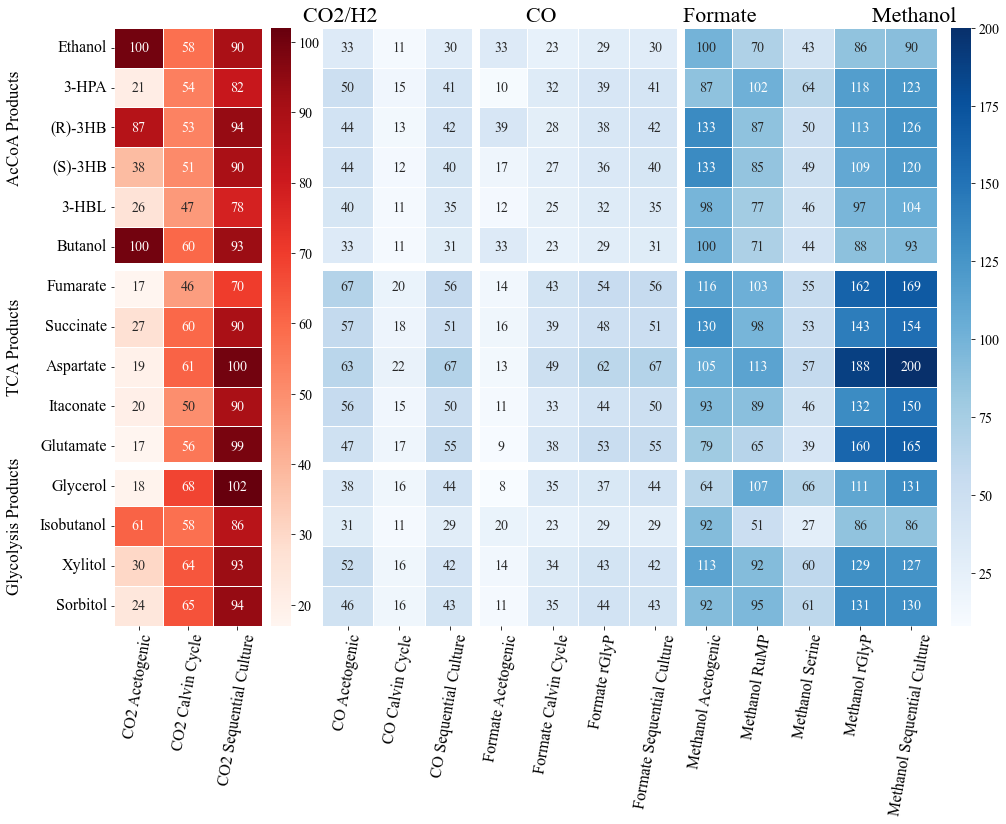

In [185]:
excel_file = 'Substrates.xlsx'
#metabolite = ["CO2", "CO2", "CO2", "CO2","Acetate Sink", "CO", "CO", "Acetate Sink", "Formate", "Formate", "Acetate Sink", "Methanol", "Methanol", "Methanol", "Acetate Sink"]
metabolite = ["H2", "H2","Acetate Sink", "CO", "CO", "Acetate Sink", "Formate", "Formate", "Formate", "Acetate Sink", "Methanol", "Methanol", "Methanol","Methanol", "Acetate Sink"]

plot_heatmaps(metabolite, excel_file)